In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [30]:
!pip install --upgrade scikit-learn 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [31]:
# Cargar datos desde CSV
filename = "ruta9oct1-2.csv"
df = pd.read_csv(filename)

# Codificar etiquetas para características categóricas
label_encoders = {
    "Line": LabelEncoder().fit(df['Line']),
    "From": LabelEncoder().fit(df['From']),
    "To": LabelEncoder().fit(df['To'])
}

for column in ['Line', 'From', 'To']:
    df[column] = label_encoders[column].transform(df[column])

## Dividir datos en entrenamiento y prueba
X = df[['Line', 'From', 'To']]
y = df['TP']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir el modelo y ajustar hiperparámetros
model = Ridge()
params = {
    'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]
}

# Usar GridSearchCV para buscar el mejor hiperparámetro
grid_search = GridSearchCV(model, params, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

# Imprimir el mejor hiperparámetro y el modelo correspondiente
print("Mejor hiperparámetro alpha:", grid_search.best_params_)
print("Mejor score (MSE):", -grid_search.best_score_)
best_model = grid_search.best_estimator_

# Crear y entrenar el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

graph = {}
for index, row in df.iterrows():
    from_station = label_encoders['From'].inverse_transform([int(row['From'])])[0]  # Corrección aquí
    to_station = label_encoders['To'].inverse_transform([int(row['To'])])[0]  # Y aquí
    
    predicted_time = model.predict([[row['Line'], row['From'], row['To']]])[0]
    
    if from_station not in graph:
        graph[from_station] = {}
    graph[from_station][to_station] = predicted_time
    
    
def dijkstra(graph, start, end):
    shortest_path = {}
    predecessor = {}
    unseen_nodes = graph.copy()  # Copiamos el grafo para no modificar el original
    infinity = float('inf')
    path = []
    for node in unseen_nodes:
        shortest_path[node] = infinity
    shortest_path[start] = 0

    while unseen_nodes:
        min_node = None
        for node in unseen_nodes:
            if min_node is None:
                min_node = node
            elif shortest_path[node] < shortest_path[min_node]:
                min_node = node

        path_options = graph[min_node].items()
        for child_node, weight in path_options:
            # Verificamos si child_node ya ha sido inicializado en shortest_path
            if child_node in shortest_path:
                if weight + shortest_path[min_node] < shortest_path[child_node]:
                    shortest_path[child_node] = weight + shortest_path[min_node]
                    predecessor[child_node] = min_node
        unseen_nodes.pop(min_node)

    current_node = end
    while current_node != start:
        try:
            path.insert(0, current_node)
            current_node = predecessor[current_node]
        except KeyError:
            print("Path not reachable")
            break
    path.insert(0, start)
    if shortest_path[end] != infinity:
        return path, shortest_path[end]
    else:
        return None, None 

print(graph)
    


Mejor hiperparámetro alpha: {'alpha': 20}
Mejor score (MSE): 0.7489604530787247
{'Terminal CAPU': {'Boulevard Norte': 4.822290818695211}, 'Boulevard Norte': {'Hidalgo': 4.801287947170146}, 'Hidalgo': {'Unión': 4.927505091649131}, 'Unión': {'China Poblana': 4.841089303629678}, 'China Poblana': {'Santa María': 4.8903942505042695, 'Los Lavaderos': 4.916742736946101}, 'Santa María': {'San Antonio': 4.932699245272956}, 'San Antonio': {'Xanenetla': 4.962112294484838}, 'Xanenetla': {'San Francisco': 4.949966349346412}, 'San Francisco': {'Analco': 4.802771167439853}, 'Analco': {'Clinica 2': 4.767061771308848}, 'Clinica 2': {'Niños Heroes': 4.85463669378196}, 'Niños Heroes': {'Fiscalia': 4.838779815289416}, 'Fiscalia': {'Parque Juárez': 4.87278700708433}, 'Parque Juárez': {'16 de Septiembre': 4.779718679268836}, '16 de Septiembre': {'Capitan Carlos Camacho Espiritu': 4.752120209106089}, 'Capitan Carlos Camacho Espiritu': {'Cristal': 4.780796038466644}, 'Cristal': {'Bomberos': 4.762791714541862}

In [32]:
# Realizar predicciones para calcular MSE
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# Calcular el camino más corto
path, distance = dijkstra(graph, 'China Poblana', 'Chachapa')
print(f"Ruta más corta (basado en predicciones): {' -> '.join(path)}")
print(f"Tiempo total predicho: {distance:.2f} minutos\n")

# Calcular el camino más corto
path, distance = dijkstra(graph, 'China Poblana', 'La Fragua')
print(f"Ruta más corta (basado en predicciones): {' -> '.join(path)}")
print(f"Tiempo total predicho: {distance:.2f} minutos")

Mean Squared Error (MSE): 0.13289584263812354
Ruta más corta (basado en predicciones): China Poblana -> Los Lavaderos -> Puente Zaragoza -> Ignacio Zaragoza -> Los Fuertes -> Tecnológico -> La Ciénega -> 18 de Noviembre -> La Resurrección -> Universidad Tecnológica -> Rivera Anaya -> Amalucan -> Galaxia -> El Pilar -> Santa Mago -> Mixatlac -> Chachapa
Tiempo total predicho: 78.95 minutos

Ruta más corta (basado en predicciones): China Poblana -> Santa María -> San Antonio -> Xanenetla -> San Francisco -> Analco -> Clinica 2 -> Niños Heroes -> Fiscalia -> Parque Juárez -> 16 de Septiembre -> Capitan Carlos Camacho Espiritu -> Cristal -> Bomberos -> San Baltazar -> Margaritas -> CU BUAP -> Biblioteca Central -> Las Torres -> Xilotzingo -> Arboledas -> La Fragua
Tiempo total predicho: 101.67 minutos


In [33]:
# Cargar datos desde CSV
filename = "ruta9oct1.4-2.csv"
df4 = pd.read_csv(filename)

# Codificar etiquetas para características categóricas
label_encoders = {
    "Line": LabelEncoder().fit(df4['Line']),
    "From": LabelEncoder().fit(df4['From']),
    "To": LabelEncoder().fit(df4['To'])
}

for column in ['Line', 'From', 'To']:
    df4[column] = label_encoders[column].transform(df4[column])

# Dividir datos en entrenamiento y prueba
X = df4[['Line', 'From', 'To']]
y = df4['TP']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir el modelo y ajustar hiperparámetros
model = Ridge()
params = {
    'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]
}

# Usar GridSearchCV para buscar el mejor hiperparámetro
grid_search = GridSearchCV(model, params, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

# Imprimir el mejor hiperparámetro y el modelo correspondiente
print("Mejor hiperparámetro alpha:", grid_search.best_params_)
print("Mejor score (MSE):", -grid_search.best_score_)
best_model = grid_search.best_estimator_

# Crear y entrenar el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

graph = {}
for index, row in df4.iterrows():
    from_station = label_encoders['From'].inverse_transform([int(row['From'])])[0]  # Corrección aquí
    to_station = label_encoders['To'].inverse_transform([int(row['To'])])[0]  # Y aquí
    
    predicted_time = model.predict([[row['Line'], row['From'], row['To']]])[0]
    
    if from_station not in graph:
        graph[from_station] = {}
    graph[from_station][to_station] = predicted_time
    
    
def dijkstra(graph, start, end):
    shortest_path = {}
    predecessor = {}
    unseen_nodes = graph.copy()  # Copiamos el grafo para no modificar el original
    infinity = float('inf')
    path = []
    for node in unseen_nodes:
        shortest_path[node] = infinity
    shortest_path[start] = 0

    while unseen_nodes:
        min_node = None
        for node in unseen_nodes:
            if min_node is None:
                min_node = node
            elif shortest_path[node] < shortest_path[min_node]:
                min_node = node

        path_options = graph[min_node].items()
        for child_node, weight in path_options:
            # Verificamos si child_node ya ha sido inicializado en shortest_path
            if child_node in shortest_path:
                if weight + shortest_path[min_node] < shortest_path[child_node]:
                    shortest_path[child_node] = weight + shortest_path[min_node]
                    predecessor[child_node] = min_node
        unseen_nodes.pop(min_node)

    current_node = end
    while current_node != start:
        try:
            path.insert(0, current_node)
            current_node = predecessor[current_node]
        except KeyError:
            print("Path not reachable")
            break
    path.insert(0, start)
    if shortest_path[end] != infinity:
        return path, shortest_path[end]
    else:
        return None, None 

print(graph)

Mejor hiperparámetro alpha: {'alpha': 20}
Mejor score (MSE): 5.517998894240286
{'Chachapa': {'Flor del Bosque': 7.085800894854588}, 'Flor del Bosque': {'Francisco Javier Clavijero': 6.331404921700225}, 'Francisco Javier Clavijero': {'Emiliano Zapata': 6.502664429530202}, 'Emiliano Zapata': {'Valsequillo': 5.25430648769575}, 'Valsequillo': {'San Francisco Totuimehuacan': 3.8969574944071583}, 'San Francisco Totuimehuacan': {'Los Héroes': 4.822612975391499}, 'Los Héroes': {'Hospital General': 5.577008948545862}, 'Hospital General': {'Periférico': 5.405749440715884}, 'Periférico': {'Prolongación 19 sur': 4.8424295302013425}, 'Prolongación 19 sur': {'Ciudad  Judicial': 5.919527964205817}, 'Ciudad  Judicial': {'Tlaxcalcingo': 5.626550335570471}, 'Tlaxcalcingo': {'Tlaxcalcingo': 3.9068657718120803}}


In [34]:
#Guardar la suma total del tiempo en todas las rutas para llegar de a a b
sumtot = 101.67+78.95
sumtot

180.62

In [35]:
# Realizar predicciones para calcular MSE
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# Calcular el camino más corto
path, distance = dijkstra(graph, 'Chachapa', 'Valsequillo')
print(f"Ruta más corta (basado en predicciones): {' -> '.join(path)}")
print(f"Tiempo total predicho: {distance:.2f} minutos")

Mean Squared Error (MSE): 0.32483994086686224
Ruta más corta (basado en predicciones): Chachapa -> Flor del Bosque -> Francisco Javier Clavijero -> Emiliano Zapata -> Valsequillo
Tiempo total predicho: 25.17 minutos


In [36]:
# Resta de los dos tiempo 
diftot = sumtot-25.17
diftot

155.45

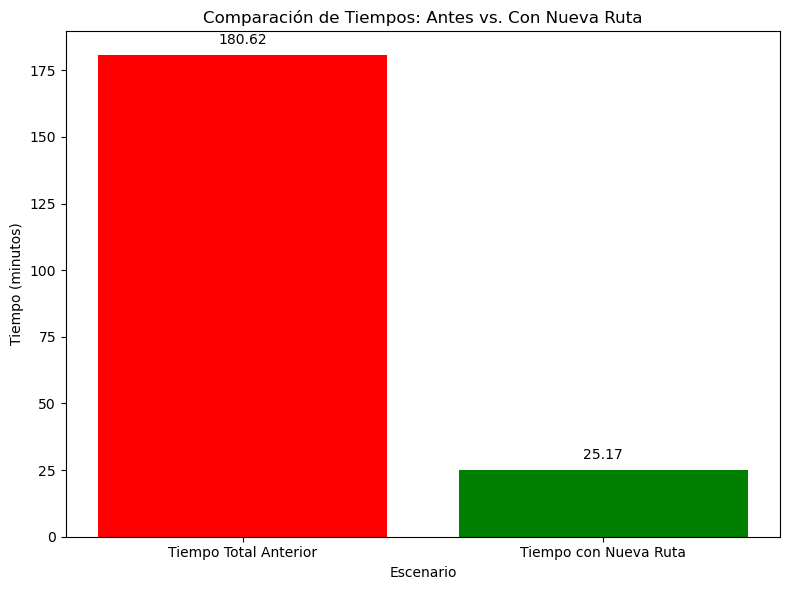

In [37]:
# Datos para la gráfica
labels = ['Tiempo Total Anterior', 'Tiempo con Nueva Ruta']
values = [sumtot, 25.17]

# Configuración de la gráfica
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, values, color=['red', 'green'])

# Añadir título y etiquetas
plt.title('Comparación de Tiempos: Antes vs. Con Nueva Ruta')
plt.ylabel('Tiempo (minutos)')
plt.xlabel('Escenario')

# Mostrar valores en las barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 3, round(yval, 2), ha='center', va='bottom')

# Mostrar la gráfica
plt.tight_layout()
plt.show()

In [38]:
# Datos proporcionados
tiempo_ahorrado_por_persona = diftot  # minutos
co2_ahorrado_por_minuto = 0.0042  # kg CO2/min por persona
num_personas = 3000000/30  # número de personas al día

# Cálculo del ahorro total de CO2
total_co2_ahorrado = tiempo_ahorrado_por_persona * co2_ahorrado_por_minuto * num_personas

print(f"Total de CO2 ahorrado por 100,000 de personas al día: {total_co2_ahorrado:.2f} kg")


Total de CO2 ahorrado por 100,000 de personas al día: 65289.00 kg


In [39]:
# Datos anteriores
tiempo_no_ahorrado= sumtot
tiempo_ahorrado_por_persona = 25.17  # minutos
co2_ahorrado_por_minuto = 0.0042  # kg CO2/min por persona
num_personas = 3000000/30  # número de personas al día

# Cálculo del ahorro total de CO2
total_co2= tiempo_no_ahorrado*co2_ahorrado_por_minuto*num_personas
total_co2_ahorrado = tiempo_ahorrado_por_persona * co2_ahorrado_por_minuto * num_personas

# Datos sobre la absorción de CO2 por árbol
absorcion_minima = 10  # kg/año
absorcion_maxima = 30  # kg/año

# Cálculo de la cantidad de árboles necesarios
num_arboles_min_antes = total_co2/ absorcion_maxima
num_arboles_max_antes = total_co2/ absorcion_minima

# Cálculo de la cantidad de árboles necesarios
num_arboles_min = total_co2_ahorrado / absorcion_maxima
num_arboles_max = total_co2_ahorrado / absorcion_minima

print(f"Se necesitarían entre {num_arboles_min_antes:.2f} y {num_arboles_max_antes:.2f} árboles para absorber el CO2 antes de implementar la ruta 4")
print(f"Se necesitarían entre {num_arboles_min:.2f} y {num_arboles_max:.2f} árboles para absorber el CO2 después de implementar la ruta 4")

Se necesitarían entre 2528.68 y 7586.04 árboles para absorber el CO2 antes de implementar la ruta 4
Se necesitarían entre 352.38 y 1057.14 árboles para absorber el CO2 después de implementar la ruta 4


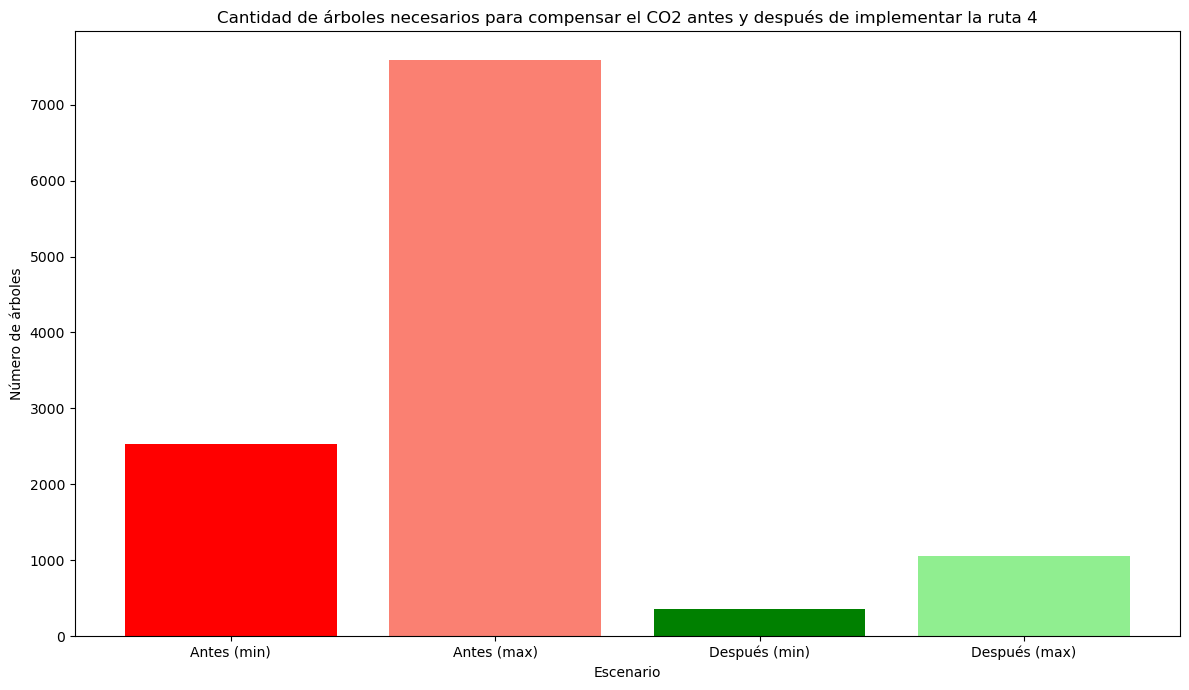

In [40]:
# Datos
labels = ['Antes (min)', 'Antes (max)', 'Después (min)', 'Después (max)']
values = [num_arboles_min_antes, num_arboles_max_antes, num_arboles_min, num_arboles_max]

# Configuración de la gráfica
plt.figure(figsize=(12,7))
plt.bar(labels, values, color=['red', 'salmon', 'green', 'lightgreen'])

# Añadir título y etiquetas
plt.title('Cantidad de árboles necesarios para compensar el CO2 antes y después de implementar la ruta 4')
plt.ylabel('Número de árboles')
plt.xlabel('Escenario')

# Mostrar la gráfica
plt.tight_layout()
plt.show()